In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
import warnings
warnings.filterwarnings("ignore")


class PortfolioOptimizer:
    """
    Same API as before, but improved robustness when fetching data from yfinance,
    ensuring TSLA is present in historical assets, and aligning mu/cov before optimization.
    """

    def __init__(self,
                 tsla_forecast_prices: pd.Series,
                 hist_assets: list = ['TSLA', 'BND', 'SPY'],
                 hist_start: str = "2015-01-01",
                 hist_end: str = None,
                 forecast_trading_days: int = 252):
        # ensure TSLA is present so covariance matrix includes it
        hist_assets = list(dict.fromkeys(list(hist_assets)))  # preserve order, de-dupe
        if 'TSLA' not in hist_assets:
            hist_assets = ['TSLA'] + hist_assets
        self.tsla_forecast_prices = tsla_forecast_prices.copy().dropna()
        self.hist_assets = hist_assets
        self.hist_start = hist_start
        self.hist_end = hist_end or pd.Timestamp.today().strftime("%Y-%m-%d")
        self.forecast_trading_days = forecast_trading_days

        # Will be set later
        self.price_hist = None                 # historical adj-close prices (DataFrame)
        self.daily_returns = None              # daily returns DataFrame
        self.cov_annual = None                 # annualized covariance DataFrame
        self.expected_annual_returns = None    # pd.Series indexed by asset tickers (annualized)
        self.ef = None                         # EfficientFrontier object (not strictly required)
        self.max_sharpe = None
        self.min_vol = None
        self.random_portfolios = None

    # ------------------ Helpers ------------------
    @staticmethod
    def annualize_return_from_daily_mean(mean_daily_return):
        return (1 + mean_daily_return) ** 252 - 1

    @staticmethod
    def annualize_cov_from_daily_cov(daily_cov):
        return daily_cov * 252

    @staticmethod
    def portfolio_performance(weights, mu, cov):
        """
        weights: np.array
        mu: pd.Series (annual)
        cov: pd.DataFrame (annual)
        returns annualized scalar, volatility scalar, sharpe (rf=0)
        """
        ret = float(np.dot(weights, mu.values))
        vol = float(np.sqrt(weights.T @ cov.values @ weights))
        sharpe = ret / vol if vol != 0 else np.nan
        return ret, vol, sharpe

    # ------------------ Data fetching & preprocessing ------------------
    @staticmethod
    def _extract_adj_close(df: pd.DataFrame) -> pd.DataFrame:
        """
        yfinance sometimes returns MultiIndex columns or different column names.
        This helper tries to extract adjusted close prices robustly.
        """
        # If DataFrame is empty
        if df is None or df.shape[0] == 0:
            raise ValueError("yfinance returned no data.")

        # If columns are MultiIndex (ticker, field)
        if isinstance(df.columns, pd.MultiIndex):
            # common case: top level tickers, second level fields like 'Adj Close'
            # try to get 'Adj Close' slice
            try:
                adj = df.xs('Adj Close', axis=1, level=1, drop_level=False)
                # xs returns MultiIndex columns where second level is 'Adj Close' - reduce to single-level
                adj = adj.droplevel(axis=1, level=1)
                return adj
            except (KeyError, ValueError):
                pass

            # fallback: try to find any column with 'Adj' or 'Adj Close'
            for lvl in df.columns.levels[1]:
                if 'Adj' in str(lvl):
                    try:
                        adj = df.xs(lvl, axis=1, level=1, drop_level=False)
                        adj = adj.droplevel(axis=1, level=1)
                        return adj
                    except Exception:
                        continue
        else:
            # Not MultiIndex: look for 'Adj Close' or 'Close' or 'adjclose' etc
            cols = [c for c in df.columns]
            for candidate in ['Adj Close', 'Adj_Close', 'AdjClose', 'Close', 'close']:
                if candidate in cols:
                    return df[candidate].to_frame() if df[candidate].ndim == 1 else df[[candidate]]
            # If only a single column present (e.g., yfinance returned a Series converted to DataFrame)
            if len(cols) == 1:
                return df.iloc[:, [0]]
        # As a last resort, take the last column (often close/adj close)
        return df.iloc[:, -len(df.columns.unique(level=0)):] if isinstance(df.columns, pd.MultiIndex) else df.iloc[:, -1:].copy()

    def fetch_historical_prices(self):
        """
        Fetches adjusted close prices for self.hist_assets robustly.
        """
        print("Fetching historical prices for:", self.hist_assets)
        # Use group_by=ticker to get consistent MultiIndex format for multiple tickers
        raw = yf.download(self.hist_assets, start=self.hist_start, end=self.hist_end, progress=False, group_by='ticker')
        # Extract adj close robustly
        adj = self._extract_adj_close(raw)

        # If the extracted frame has a single unnamed column, ensure columns names match tickers
        # If columns are not named by tickers (e.g., single series), ensure naming
        if isinstance(adj, pd.Series):
            adj = adj.to_frame(name=self.hist_assets[0])

        # If adj has columns but names are tickers - good. Otherwise try to rename by hist_assets order.
        if list(adj.columns) != self.hist_assets:
            # If count matches, rename to requested tickers (best-effort)
            if adj.shape[1] == len(self.hist_assets):
                adj.columns = self.hist_assets
            else:
                # otherwise keep existing column names, but warn
                print("Warning: returned historical columns differ from requested tickers. Columns:", adj.columns)

        # forward-fill and drop rows where all are NA
        adj = adj.dropna(how='all').ffill().dropna()
        if adj.empty:
            raise ValueError("No historical price data after cleaning/forward-filling.")

        self.price_hist = adj
        self.daily_returns = adj.pct_change().dropna()
        print("Historical data fetched. Shape:", self.price_hist.shape)
        # print returned columns for debugging convenience
        print("Returned tickers:", list(self.price_hist.columns))

    def compute_covariance(self):
        if self.daily_returns is None:
            raise RuntimeError("Historical returns not computed. Call fetch_historical_prices() first.")
        daily_cov = self.daily_returns.cov()
        self.cov_annual = self.annualize_cov_from_daily_cov(daily_cov)
        return self.cov_annual

    def compute_expected_returns(self, tsla_from_forecast=True):
        """
        Build expected annual returns Series:
         - TSLA: from forecasted price series -> daily returns mean -> annualize
         - Others (BND, SPY): historical mean daily returns -> annualize
        """
        if self.price_hist is None or self.daily_returns is None:
            raise RuntimeError("Historical data missing. Call fetch_historical_prices() first.")

        expected = {}

        # TSLA expected return from forecast
        if tsla_from_forecast:
            f = self.tsla_forecast_prices
            f_returns = f.pct_change().dropna()
            if len(f_returns) == 0:
                raise ValueError("TSLA forecast prices do not contain enough points to compute returns.")
            mean_daily = f_returns.mean()
            tsla_ann = self.annualize_return_from_daily_mean(mean_daily)
            expected['TSLA'] = tsla_ann
        else:
            if 'TSLA' not in self.daily_returns.columns:
                raise ValueError("TSLA not present in historical returns to compute historical TSLA expected return.")
            mean_daily = self.daily_returns['TSLA'].mean()
            expected['TSLA'] = self.annualize_return_from_daily_mean(mean_daily)

        # Others: use historical averages; ensure they exist in daily_returns
        for asset in self.hist_assets:
            if asset == 'TSLA':
                continue
            if asset not in self.daily_returns.columns:
                raise ValueError(f"{asset} not present in historical data.")
            mean_daily = self.daily_returns[asset].mean()
            expected[asset] = self.annualize_return_from_daily_mean(mean_daily)

        # Construct pandas Series and ensure ordering is consistent later
        self.expected_annual_returns = pd.Series(expected)
        print("\nExpected annual returns (from forecast for TSLA, historical for others):")
        print(self.expected_annual_returns)
        return self.expected_annual_returns

    # ------------------ Optimization & frontier ------------------
    def optimize_portfolios(self, n_random=10000, random_seed=42):
        """
        - Uses random portfolios for the Efficient Frontier scatter.
        - Uses PyPortfolioOpt to compute exact max Sharpe and min vol portfolios given mu and cov.
        """
        if self.cov_annual is None or self.expected_annual_returns is None:
            raise RuntimeError("Covariance or expected returns missing. Run compute_covariance and compute_expected_returns first.")

        # Align mu and cov: enforce same order and same assets
        # Keep only intersection of assets present in both, and maintain order
        common = [a for a in self.expected_annual_returns.index if a in self.cov_annual.index]
        if len(common) != len(self.expected_annual_returns):
            missing = set(self.expected_annual_returns.index) - set(common)
            raise RuntimeError(f"The following assets are missing from covariance matrix: {missing}. Ensure historical data includes them.")

        mu = self.expected_annual_returns.loc[common]
        cov = self.cov_annual.loc[common, common]

        np.random.seed(random_seed)
        n_assets = len(mu)
        assets = list(mu.index)

        # generate random portfolios
        weights = np.random.dirichlet(np.ones(n_assets), n_random)
        rets = weights @ mu.values
        vols = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov.values, weights))
        sharpes = rets / vols

        random_portfolios = pd.DataFrame({
            'ret': rets,
            'vol': vols,
            'sharpe': sharpes
        })
        random_portfolios['weights'] = list(weights)
        self.random_portfolios = random_portfolios

        # Use PyPortfolioOpt to compute exact portfolios
        ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
        ef.max_sharpe()
        max_sharpe_w = ef.clean_weights()
        max_sharpe_w_array = np.array([max_sharpe_w.get(a, 0.0) for a in mu.index])
        max_sharpe_perf = self.portfolio_performance(max_sharpe_w_array, mu, cov)

        ef2 = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
        ef2.min_volatility()
        min_vol_w = ef2.clean_weights()
        min_vol_w_array = np.array([min_vol_w.get(a, 0.0) for a in mu.index])
        min_vol_perf = self.portfolio_performance(min_vol_w_array, mu, cov)

        # store results but ensure weights dictionaries include all mu.index assets (for consistent output)
        def complete_weights_dict(wdict):
            return {a: float(wdict.get(a, 0.0)) for a in mu.index}

        self.max_sharpe = {'weights': complete_weights_dict(max_sharpe_w), 'perf': max_sharpe_perf}
        self.min_vol = {'weights': complete_weights_dict(min_vol_w), 'perf': min_vol_perf}

        print("\nOptimization complete: found Max Sharpe & Min Vol portfolios.")
        return self.max_sharpe, self.min_vol

    # ------------------ Plotting ------------------
    def plot_efficient_frontier(self, show_assets=True):
        if self.random_portfolios is None or self.max_sharpe is None or self.min_vol is None:
            raise RuntimeError("Run optimize_portfolios() before plotting.")

        plt.figure(figsize=(12, 8))
        sc = plt.scatter(self.random_portfolios['vol'], self.random_portfolios['ret'],
                         c=self.random_portfolios['sharpe'], cmap='viridis', alpha=0.25, s=8)
        cb = plt.colorbar(sc)
        cb.set_label('Sharpe Ratio')

        # Mark optimal portfolios
        ms = self.max_sharpe['perf']
        mv = self.min_vol['perf']

        plt.scatter(ms[1], ms[0], marker='*', color='red', s=250, label='Max Sharpe')
        plt.scatter(mv[1], mv[0], marker='*', color='blue', s=250, label='Min Volatility')

        if show_assets:
            asset_rets = pd.Series({k: v for k, v in self.expected_annual_returns.items() if k in self.cov_annual.index})
            asset_vols = np.sqrt(np.diag(self.cov_annual.loc[asset_rets.index, asset_rets.index]))
            for i, asset in enumerate(asset_rets.index):
                plt.scatter(asset_vols[i], asset_rets[asset], marker='o', s=120, edgecolor='k')
                plt.text(asset_vols[i] * 1.01, asset_rets[asset] * 1.01, asset)

        plt.xlabel('Annualized Volatility (Std Dev)')
        plt.ylabel('Annualized Return')
        plt.title('Efficient Frontier (random portfolios) - Marked: Max Sharpe & Min Volatility')
        plt.legend()
        plt.grid(alpha=0.2)
        plt.show()

    # ------------------ Reporting ------------------
    def summarize(self):
        def pretty_print(port):
            w = port['weights']
            perf = port['perf']
            ret, vol, sharpe = perf
            print(f"Expected annual return: {ret:.2%}")
            print(f"Annual volatility: {vol:.2%}")
            print(f"Sharpe Ratio: {sharpe:.3f}")
            print("Weights:")
            for k, v in w.items():
                print(f"  {k}: {v:.2%}")

        print("\n--- MAX SHARPE PORTFOLIO ---")
        pretty_print(self.max_sharpe)

        print("\n--- MIN VOLATILITY PORTFOLIO ---")
        pretty_print(self.min_vol)

    def recommend(self, preference='max_sharpe'):
        """
        preference: 'max_sharpe' or 'min_vol'
        """
        if preference == 'max_sharpe':
            choice = self.max_sharpe
            rationale = ("Prioritizing risk-adjusted returns (higher Sharpe). "
                         "Suitable if investor tolerates moderate volatility for higher expected return.")
        else:
            choice = self.min_vol
            rationale = ("Prioritizing lower volatility. Suitable if investor wants capital preservation / lower drawdowns.")

        print("\n--- RECOMMENDATION ---")
        print(rationale)
        self._print_choice(choice)

    def _print_choice(self, choice):
        w = choice['weights']
        perf = choice['perf']
        print("\nRecommended Portfolio:")
        for k, v in w.items():
            print(f"  {k}: {v:.2%}")
        print("\nPerformance:")
        print(f"  Expected annual return: {perf[0]:.2%}")
        print(f"  Annual volatility: {perf[1]:.2%}")
        print(f"  Sharpe Ratio: {perf[2]:.3f}")


[*********************100%***********************]  1 of 1 completed


Fetching historical prices for: ['TSLA', 'BND', 'SPY']
Historical data fetched. Shape: (2666, 3)
Returned tickers: ['TSLA', 'BND', 'SPY']

Expected annual returns (from forecast for TSLA, historical for others):
TSLA         0.000000
BND          0.150608
SPY     392995.104780
dtype: float64

Optimization complete: found Max Sharpe & Min Vol portfolios.


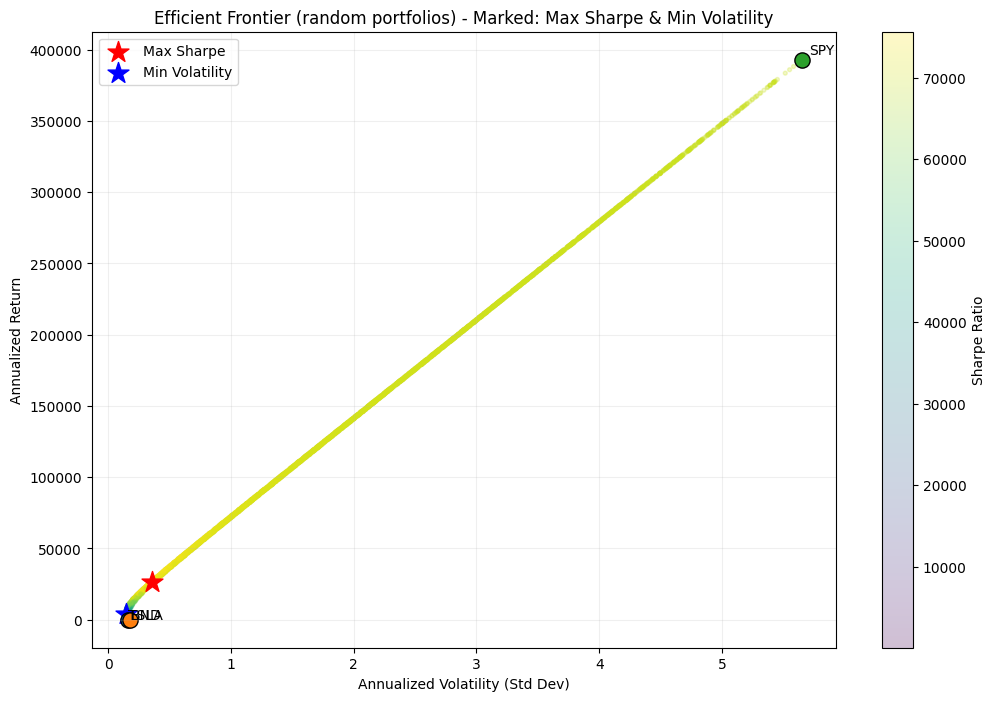


--- MAX SHARPE PORTFOLIO ---
Expected annual return: 2681012.60%
Annual volatility: 35.44%
Sharpe Ratio: 75649.748
Weights:
  TSLA: 93.18%
  BND: 0.00%
  SPY: 6.82%

--- MIN VOLATILITY PORTFOLIO ---
Expected annual return: 431905.58%
Annual volatility: 14.39%
Sharpe Ratio: 30012.349
Weights:
  TSLA: 72.62%
  BND: 26.28%
  SPY: 1.10%

--- RECOMMENDATION ---
Prioritizing risk-adjusted returns (higher Sharpe). Suitable if investor tolerates moderate volatility for higher expected return.

Recommended Portfolio:
  TSLA: 93.18%
  BND: 0.00%
  SPY: 6.82%

Performance:
  Expected annual return: 2681012.60%
  Annual volatility: 35.44%
  Sharpe Ratio: 75649.748


In [10]:
if __name__ == "__main__":
    import yfinance as yf
    import pandas as pd

    # quick naive forecast (replace with your model output)
    df = yf.download("TSLA", start="2015-01-01", end=pd.Timestamp.today().strftime("%Y-%m-%d"))
    # try to get Adj Close robustly
    try:
        tsla_hist = df['Adj Close'] if 'Adj Close' in df.columns else df.iloc[:, -1]
    except Exception:
        tsla_hist = df.iloc[:, -1]

    last_price = tsla_hist.iloc[-1]
    future_index = pd.bdate_range(start=tsla_hist.index[-1] + pd.Timedelta(days=1), periods=252)
    naive_forecast = pd.Series(last_price, index=future_index, name="TSLA_forecast")

    optimizer = PortfolioOptimizer(tsla_forecast_prices=naive_forecast,
                                   hist_assets=['TSLA', 'BND', 'SPY'],
                                   hist_start="2015-01-01")

    optimizer.fetch_historical_prices()
    optimizer.compute_covariance()
    optimizer.compute_expected_returns(tsla_from_forecast=True)
    optimizer.optimize_portfolios(n_random=5000)
    optimizer.plot_efficient_frontier(show_assets=True)
    optimizer.summarize()
    optimizer.recommend('max_sharpe')
